### Constantin Gleyze - Ecole Polytechnique & Sorbonne University

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">Introduction</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

The goal of this project is test a deep hedging approach to hedge an option. In this particular project, we will look for vanilla options in order to compare it with the delta hedging. 

We therefore consider a vanilla option (a call in this projet) $(C_t)_{t \in [0,T]}$ on an underlying, which has under the risk neutral probability $\mathbb{Q}$ the following dynamic : 

$\forall t \in [0,T], \space dS_t = S_t((r - q)dt + \sigma dW_t)$

with $r$ the risk-free interest rate, $q$ the continuous dividend yield, $\sigma$ the volatility and $(W_t)_{t \in [0,T]}$ a geometric brownian motion under $\mathbb{Q}$. 

The payoff of the option $C_t$ is then $\varphi(S_T)$ for all $t \in [0,T]$. 

We pose as $(\mathcal{F}_{t})_{t \in [0,T]}$ the natural filtration of the process $S$. 

We discretise $T$ in $N$ steps $t_0$,....,$t_N$, corresponding to the time at which our hedging strategy is rebalanced.

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">Discrete-time hedging formula</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

We place ourselves in the position of the trader who sold the option and wants to hedge the position.

We define the initial value of the hedging portfolio as:

$V_0 = P_0 - \alpha_0 S_0$ 

with : 
- $\alpha_0$ the quantity of the underlying at time $t_0$
- $S_0$ the price of the underlying at time $t_0$
- $P_0$ the price of the option at time $t_0$
- $V_0$ the hedging portfolio value at time $t_0$

Between two rebalancing dates, we invest (or borrow) the cash position at the risk-free rate $r$. We also update the position in the underlying at the beginning of each new period.

Hence, the portfolio dynamics between rebalancing dates are given by:

$V_n = e^{r \frac{T}{N}} V_{n-1} - (\alpha_n - \alpha_{n-1}) S_{n}$

At maturity, the trader unwinds the position and delivers the payoff:
$V_N = e^{r \frac{T}{N}} V_{N-1} + \alpha_{N-1} S_{N} - Z_T$

We introduce discounted quantities:

- $\tilde{V}n = e^{-r n \frac{T}{N}} V_n$
- $\tilde{S}{n} = e^{-r n \frac{T}{N}} S_{n}$
- $\tilde{Z}_T = e^{-r T} \varphi(S_T)$

We obtain the following relationship with the discounted values for $n = 1, \dots, N-1$: 

  $
    \begin{cases}
        \tilde{V}_0 = V_0 \\
        \tilde{V}_n = \tilde{V}_{n-1} - (\alpha_n - \alpha_{n-1}) \tilde{S}_{n}
    \end{cases}$

with the final condition, which will be used as the training target for our neural network:

**$ \tilde{V}_N = \tilde{V}_{N-1} + \alpha_{N-1}\tilde {S}_T - \tilde{Z}_T$**

It is also possible to include transaction costs in this relation if desired. Alternatively, one can adjust the volatility (see Leland), which in turn modifies the delta-hedging strategy the neural network aims to approximate.



In [20]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme()
import torch
from torch import nn
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import copy
from scipy.stats import norm
import json
import torch.nn.functional as F

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">Functions to simulate paths and compute BS price/delta</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

In [6]:
def price_call_BS(spot: float, t: float, r: float = 0, sigma: float = 0, strike: float = 0) -> float:
    """
    Compute the Black-Scholes price for a European call option.

    Parameters
    ----------
    spot   : float
             Current spot price of the underlying asset.
    t      : float
             Time to maturity (in years).
    r      : float, optional
             Risk-free interest rate (default: 0).
    sigma  : float, optional
             Volatility of the underlying asset (default: 0).
    strike : float, optional
             Strike price of the option (default: 0).

    Returns
    -------
    float
        The price of the European call option.
    """
    d1_ = (np.log(spot / strike) + t * (r + 0.5 * sigma**2)) / (sigma * np.sqrt(t)) # Compute d1
    d2_ = d1_ - sigma * np.sqrt(t)  # Compute d2
    return spot * norm.cdf(d1_) - strike * np.exp(-r * t) * norm.cdf(d2_)  # Black-Scholes formula

def price_put_BS(spot: float, t: float, r: float = 0, sigma: float = 0, strike: float = 0) -> float:
    
    """
    Compute the Black-Scholes price for a European put option.

    Parameters
    ----------
    spot   : float
             Current spot price of the underlying asset.
    t      : float
             Time to maturity (in years).
    r      : float, optional
             Risk-free interest rate (default: 0).
    sigma  : float, optional
             Volatility of the underlying asset (default: 0).
    strike : float, optional
             Strike price of the option (default: 0).

    Returns
    -------
    float
        The price of the European put option.
    """
    
    return price_call_BS(spot, t, r, sigma, strike) - spot + strike * np.exp(-r * t)  # Put-call parity

def dprice_call_BS(spot: float, t: float, r: float, sigma: float, strike: float) -> float:
    
    """
    Compute the delta of a European call option (sensitivity to spot price).

    Parameters
    ----------
    spot   : float
             Current spot price of the underlying asset.
    t      : float
             Time to maturity (in years).
    r      : float
             Risk-free interest rate.
    sigma  : float
             Volatility of the underlying asset.
    strike : float
             Strike price of the option.

    Returns
    -------
    float
        The delta of the call option.
    """
    
    d1 = (np.log(spot / strike) + t * (r + 0.5*sigma**2)) / (sigma * np.sqrt(t))

    return norm.cdf(d1)

def monte_carlo(sample, proba: float = 0.95) -> dict:
    
    """
    Compute the Monte Carlo estimate of the mean, variance, and confidence interval.

    Parameters
    ----------
    sample : numpy.ndarray or torch.Tensor
             The sample data.
    proba  : float, optional
             Confidence level for the confidence interval (default: 0.95).

    Returns
    -------
    dict
        A dictionary containing the mean, variance, and confidence interval bounds.
    """
    
    # If input is a NumPy array, convert it to a PyTorch tensor
    if isinstance(sample, np.ndarray):
        sample = torch.tensor(sample, dtype=torch.float32)

    mean = torch.mean(sample)  # Compute sample mean
    var = torch.var(sample, unbiased=True)  # Compute unbiased sample variance

    alpha = 1 - proba  # Compute alpha for confidence level
    quantile = stats.norm.ppf(1 - alpha / 2)  # Compute the normal quantile for CI
    ci_size = quantile * torch.sqrt(var / sample.numel())  # Compute the confidence interval size

    return {
        'Mean': mean.item(),  # mean 
        'Var': var.item(), # variance
        'Lower bound': (mean - ci_size).item(),  # Lower bound of confidence interval
        'Upper bound': (mean + ci_size).item()   # Upper bound of confidence interval
    }


In [7]:
def simu_S(N: int, M: int, x0: float, r: float, sigma: float, T: float) -> np.ndarray:
    
    """
    Simulate asset price paths using the BS dynamic.

    Parameters
    ----------
    N     : int
            Number of time steps.
    M     : int
            Number of simulated paths.
    x0    : float
            Initial asset price.
    r     : float
            Risk-free interest rate.
    sigma : float
            Volatility of the asset.
    T     : float
            Time horizon (in years).

    Returns
    -------
    np.ndarray
        A (N+1, M) array representing the simulated asset price paths.
    """
    
    dt = T / N  # Time step size
    brown_acc = np.sqrt(dt) * np.random.standard_normal(size=(N, M))  # Brownian increments

    sample = np.zeros(shape=(N+1, M))  # Initialize matrix to store price paths
    sample[0] = x0  # Set initial price

    # Iterate through time steps to simulate paths
    for n in range(1, N+1):
        sample[n] = sample[n - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * brown_acc[n - 1])  # GBM formula

    return sample  # Return the simulated paths


<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">Neural Network</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

### Several activation functions have been tested, which are listed below:

**1. ReLU (Rectified Linear Unit)**

Defined by : 

$f(x) = \max(0, x)$

Usual activation function, fast but can have dead neurons (when input values are negative). 

**2. Leaky ReLU**

Defined by : 

$
f(x) =
\begin{cases}
x & \text{it } x > 0 \\[6pt]
\alpha x & \text{if } x \leq 0
\end{cases},\quad \text{with } \alpha \text{ small (for instance }0.01\text{)}
$

This function avoids dead neurons by maintaining a small non-zero gradient.

**3. SiLU**

Defined by : 

$f(x) = x \cdot \sigma(x) = \frac{x}{1 + e^{-x}}$ with $\sigma(x) = \frac{1}{1 + e^{-x}}$ the sigmoid function 
This function also helps avoid dead neurons and provides smoother gradients since it is differentiable everywhere.


We obtain best result with **ReLU** and **SiLU**. However, the plot of SiLU function provided much more smoother functions, better fitting the delta-hedge function. We therefore chose it for our NeuralNetwork after several tests. 

We also added the **sigmoid** function to the output of our Neural Network because the value we are wiating for are between $[0,1]$. 

In [8]:
class NeuralNetwork(nn.Module):
    
    """
    A feedforward neural network with customizable architecture.

    Parameters
    ----------
    input_size  : int
                  Number of input features.
    layer_sizes : list of int
                  List containing the number of neurons in each hidden layer.
    output_size : int
                  Number of output neurons.

    Methods
    -------
    forward(x)
        Forward pass of the neural network.
    """
    
    def __init__(self, input_size: int, layer_sizes: list, output_size: int):
        super().__init__()
        # Initialize the layers list with the first hidden layer and activation
        layers = [nn.Linear(input_size, layer_sizes[0]), nn.SiLU()]
        
        # Create hidden layers dynamically
        for (ls_in, ls_out) in zip(layer_sizes, layer_sizes[1:]):
            layers.append(nn.Linear(ls_in, ls_out))
            layers.append(nn.SiLU())
            
        # Add the final output layer
        layers.append(nn.Linear(layer_sizes[-1], output_size))
        
        # Create a sequential container with all layers
        self.linear_relu_stack = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        """
        Forward pass through the neural network.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor.

        Returns
        -------
        torch.Tensor
            Output tensor after passing through the network.
        """
        
        out1 = self.linear_relu_stack(x)  # Pass input through hidden layers
        out2 = torch.sigmoid(out1)  # Apply sigmoid activation to keep the predicted value between 0 and 1 to the output layer
        return out2


<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;"> P&L function to be minimized to 0</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

In [9]:
def pnl_function(V0: float, X: torch.Tensor, X_scaled: torch.Tensor, thetas_functions: list, payoff_function, K: float, r: float, T: float,device: str = "cpu") -> torch.Tensor:
    
    """
    Compute the profit and loss (PnL) of a hedging strategy over time.

    Parameters
    ----------
    V0              : float
                      Initial portfolio value (in this case the BS price of the option)
    X               : torch.Tensor
                      Underlying asset price paths (shape: time_steps x simulations).
    X_scaled        : torch.Tensor
                      Normalized version of `X` for model input.
    thetas_functions: list
                      List of functions computing the theta value at each time step.
    payoff_function : callable
                      Function to compute the payoff at expiration.
    K               : float
                      Strike price of the option.
    r               : float
                      Risk-free interest rate.
    T               : float
                      Time to maturity.

    Returns
    -------
    torch.Tensor
        The final PnL value of the hedging strategy i.e the payoff minus the hedging self financed portfolio.
    """
    
    # Initialize portfolio value with zeros, ensuring the correct dtype and device
    V = torch.zeros_like(X, dtype=torch.float32).to(device)

    # Compute the initial hedge ratio (theta) at time step 0
    theta_0 = thetas_functions[0](X_scaled[0][:, None]).squeeze() # Compute the first quantity for the delta hedge
    V[0] = V0 - theta_0 * X[0, :]  # Initial portfolio value after applying hedge
    thetas_list = [theta_0]  # Store hedge ratios

    # Loop through time steps to update portfolio value
    for i in range(1, X.shape[0] - 1):  
        theta = thetas_functions[i](X_scaled[i][:, None]).squeeze()  # Compute hedge ratio
        V[i] = V[i - 1] - (theta - thetas_list[-1]) * X[i, :]  # Update portfolio value
        thetas_list.append(theta)  # Store theta for next iteration

    # Compute option payoff at expiration using the provided function
    payoff = payoff_function(X[-1, :], np.exp(-r * T) * K)

    # Compute final portfolio value after unwinding hedge at expiration
    V[-1] = V[-2] + thetas_list[-1] * X[-1, :] - payoff

    return V[-1]  # Return the final PnL


<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">Train function</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

In [10]:
def delta_hedge(S: np.ndarray, r: float, K: float, T: float, cste: float, payoff_function, loss_function, epochs: int, layers: list, lr: float, batch_size: int, weight_decay : float = 1e-3,device: str = "cpu") -> list:
    
    """
    Train a neural network to optimize a delta hedging strategy.

    Parameters
    ----------
    S              : np.ndarray
                     Matrix of simulated asset prices (shape: time_steps x simulations).
    r              : float
                     Risk-free interest rate.
    K              : float
                     Strike price of the option.
    T              : float
                     Time to maturity.
    cste           : float
                     Initial portfolio value.
    payoff_function: callable
                     Function computing the option payoff at expiration.
    loss_function  : callable
                     Loss function used to optimize the hedging strategy.
    epochs         : int
                     Number of training iterations.
    layers         : list
                     List specifying the number of neurons in each hidden layer of the neural networks.
    lr             : float
                     Learning rate for the optimizer.
    batch_size     : int
                     Size of the mini-batches used during training.
    weight_decay   : float
                     L2 regularization for the Adam optimizer.

    Returns
    -------
    list
        A list of trained neural network state dictionaries representing the optimal hedge ratios.
    """
    
    # Compute discount factors for each time step
    actu = np.exp(-r * np.arange(S.shape[0]) * T / (S.shape[0]-1))

    # Apply discounting to the asset price paths
    S_actu = actu[:, None] * S  
    S_actu = torch.from_numpy(S_actu.astype(np.float32)).to(device)  # Convert to torch tensor and move to device

    # Normalize the discounted asset prices
    S_actu_mean = S_actu.mean()
    S_actu_std = S_actu.std()
    S_actu_norm = (S_actu - S_actu_mean) / S_actu_std  # Standardization

    # Initialize neural networks for each time step (excluding final time step)
    theta_functions = [NeuralNetwork(1, layers, 1).to(device) for _ in range(S.shape[0] - 1)]

    # Adam optimizer with L2 regularization (weight decay)
    optimizer = torch.optim.AdamW(
        [param for theta_function in theta_functions for param in theta_function.parameters()],
        lr=lr, weight_decay=weight_decay
    )

    # Variables to track the best models
    best_loss = float("inf")  
    best_models = [{} for _ in range(len(theta_functions))]  
    M = S.shape[1]  # Number of simulated paths

    # Training loop
    with tqdm(range(epochs)) as nrange:
        epoch_loss = 0  # Track total loss for the epoch

        for n in nrange:
            indexes = torch.randperm(M)  # Shuffle sample indices
            
            for k in range(M // batch_size):  # Iterate over batches
                idx = indexes[k * batch_size : (k + 1) * batch_size]  # Select batch indices

                # Compute the PnL using the current hedge strategy
                pnl = pnl_function(cste, S_actu[:, idx], S_actu_norm[:, idx], theta_functions, payoff_function, K, r, T)
                value_to_obtain = torch.zeros_like(pnl)  # Target value (zero PnL)
                loss = loss_function(pnl, value_to_obtain)  # Compute loss
                
                optimizer.zero_grad()  # Reset gradients
                loss.backward()  # Compute gradients
                optimizer.step()  # Update model parameters
                
                epoch_loss += loss.item()  # Accumulate loss

            # Compute average loss for the epoch
            epoch_loss /= (M // batch_size)
            nrange.set_postfix(loss=epoch_loss)

            # Save best models if loss improves
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                for i, theta in enumerate(theta_functions):
                    best_models[i] = theta.state_dict().copy()  # Save model state

    return best_models  # Return the best hedge models

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">Plot functions</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

In [37]:
def plot_pnl_distribution(N: int, n_paths: int, S0: float, r: float, sigma: float, T: float, layers: list, theta_functions: list, cste: float, payoff_function, K: float, device: str = "cpu") -> None:
    
    """
    Simulate asset price paths, apply a trained delta hedging strategy, and plot the PnL distribution.

    Parameters
    ----------
    N                : int
                       Number of time steps.
    n_paths         : int
                       Number of simulated paths.
    S0              : float
                       Initial asset price.
    r               : float
                       Risk-free interest rate.
    sigma           : float
                       Volatility of the asset.
    T               : float
                       Time to maturity.
    layers          : list
                       List specifying the number of neurons in each hidden layer of the neural networks.
    theta_functions : list
                       List of pre-trained state dictionaries for the neural networks.
    cste            : float
                       Initial portfolio value.
    payoff_function : callable
                       Function computing the option payoff.
    K               : float
                       Strike price of the option.
    device          : str, optional
                       Device for computation (default: "cpu").

    Returns
    -------
    None
        Displays the PnL distribution plots and prints Monte Carlo statistics.
    """
    
    plt.figure(figsize=(10, 6))
    
    # Simulate asset price paths (returns an array of shape (N+1, n_paths))
    S = simu_S(N, n_paths, S0, r, sigma, T)
    
    # Compute discount factors (actualization coefficients)
    actu = np.exp(-r * np.arange(S.shape[0]) * T / (S.shape[0]-1))  # Avoid division by N+1 for consistency
    
    # Discount the asset price paths
    S_actu = actu[:, None] * S  
    S_actu_np = S_actu  # Keep a NumPy version for later computations
    S_actu = torch.from_numpy(S_actu.astype(np.float32)).to(device)  # Convert to PyTorch tensor
    
    # Normalize the discounted asset prices
    S_actu_mean = S_actu.mean()
    S_actu_std = S_actu.std()
    S_actu_norm = (S_actu - S_actu_mean) / S_actu_std  # Standardization

    # Load trained neural networks for delta hedging
    theta_functions_loaded = [NeuralNetwork(1, layers, 1).to(device) for _ in range(N)]
    for i, theta in enumerate(theta_functions_loaded):
        theta.load_state_dict(theta_functions[i])  # Load the pre-trained models

    # Compute the PnL using the NN-based hedge strategy
    pnl_NN = pnl_function(cste, S_actu, S_actu_norm, theta_functions_loaded, payoff_function, K, r, T)

    # Compute the PnL using the Black-Scholes delta hedge strategy
    delta = np.zeros_like(S)  # Initialize matrix to store delta values
    for n in range(N): 
        delta[n] = dprice_call_BS(S[n], (N-n)*T/N, r, sigma, K)  # Compute delta at each time step
    
    value = np.zeros_like(S)  # Initialize matrix for the portfolio value
    value[0] = cste - delta[0] * S_actu_np[0]  # Initial portfolio value including the hedge
    for n in range(1, N):
        value[n] = value[n-1] - (delta[n] - delta[n-1]) * S_actu_np[n]  # Update portfolio value at each step
    
    # Compute the option payoff at expiration
    payoff = np.exp(-r * T) * np.maximum(S[N] - K, 0)
    
    # Compute the final PnL after unwinding the hedge
    value[N] = value[N-1] + delta[N-1] * S_actu_np[N] - payoff
    pnl_delta = value[N]  # Store the final PnL for the Black-Scholes hedge

    # We plot the P&L not hedged to see the improvment 
    value0 = cste - payoff
    plt.figure(figsize=(10, 5))
    plt.hist(value0, bins=50, color="blue", alpha=0.7, edgecolor="black", density=True, label="P&L not hedged")
    plt.xlabel("P&L", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.title(f"P&L without hedge with {N} rebalancings", fontsize=16)
    plt.grid(True)
    plt.legend()
    plt.show()
    print("Statistics for the P&L not hedged:")
    print(json.dumps(monte_carlo(value0), indent=4))
    
    # Plot histogram of the PnL distributions
    plt.figure(figsize=(10, 5))
    plt.hist(pnl_NN.detach().cpu().numpy(), bins=50, color="blue", alpha=0.7, edgecolor="black", density=True, label="NN-based Hedging")
    plt.hist(pnl_delta, bins=50, color="orange", alpha=0.5, edgecolor="black", density=True, label="Classic Delta Hedging (BS)")
    plt.axvline(0, color='red', linestyle='dashed', linewidth=1, label="0")
    plt.xlabel("P&L", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.title(f"P&L for the delta-hedged strategy with {N} rebalancings", fontsize=16)
    plt.grid(True)
    plt.legend()
    plt.show()

    # Print Monte Carlo statistics
    print("Statistics for the P&L from NN:")
    print(json.dumps(monte_carlo(pnl_NN), indent=4))
    
    print("\nStatistics for the classic delta hedged P&L:")
    print(json.dumps(monte_carlo(pnl_delta), indent=4))

In [12]:
def plot_hedging_strategies(N: int, layers: list, theta_functions: list, S_actu_mean: float, S_actu_std: float, dprice_call_BS, T: float, r: float, sigma: float, K: float, device: str = "cpu") -> None:
    
    """
    Plot the evolution of hedging strategies over time using both a trained NN-based hedge
    and the classical Black-Scholes delta hedge.

    Parameters
    ----------
    N                : int
                       Number of time steps.
    layers          : list
                       List specifying the number of neurons in each hidden layer of the neural networks.
    theta_functions : list
                       List of pre-trained state dictionaries for the neural networks.
    S_actu_mean     : float
                       Mean of the scaled asset price used for normalizing input.
    S_actu_std      : float
                       Standard deviation of the scaled asset price used for normalizing input.
    dprice_call_BS  : callable
                       Function computing the delta of a European call option.
    T               : float
                       Time to maturity.
    r               : float
                       Risk-free interest rate.
    sigma           : float
                       Volatility of the underlying asset.
    K               : float
                       Strike price of the option.
    device          : str, optional
                       Device for computation (default: "cpu").

    Returns
    -------
    None
        Displays two plots comparing NN-based and Black-Scholes-based hedging strategies.
    """

    # Define the asset price grid
    S = np.linspace(50, 200, 1000)
    S_torch = torch.from_numpy(S.astype(np.float32)).to(device)  # Convert to tensor
    S_norm = (S_torch - S_actu_mean) / S_actu_std  # Normalize asset price

    # Load trained neural networks
    theta_functions_loaded = [NeuralNetwork(1, layers, 1).to(device) for _ in range(N)]
    for i, theta in enumerate(theta_functions_loaded):
        theta.load_state_dict(theta_functions[i])  

    # Plot NN-based hedge
    plt.figure(figsize=(10, 6))
    for i in range(1, N):
        theta_function = theta_functions_loaded[i]
        theta = theta_function(S_norm[:, None]).detach().cpu().numpy()
        plt.plot(S*np.exp(r*T*(i/N)), theta, label=f"Hedge at time {i}", alpha=0.6)
    if N < 20:
        plt.legend()
    plt.xlabel("Asset Price (S)", fontsize=14)
    plt.ylabel("Hedging Value", fontsize=14)
    plt.title(f"Evolution of Hedging Values Over Time (NN) with {N} rebalancings", fontsize=16)
    plt.grid(True)
    plt.show()
    
    # Plot Black-Scholes hedge
    plt.figure(figsize=(10, 6))
    for n in range(1, N):
        plt.plot(S, dprice_call_BS(S_torch, (N - n) * T / N, r, sigma, K), label=f"Hedge at time {n}", alpha=0.6)
    
    if N < 20:
        plt.legend()
    plt.xlabel("Asset Price (S)", fontsize=14)
    plt.ylabel("Hedging Value", fontsize=14)
    plt.title(f"Hedging Values Based on the Call Option Derivative (BS) with {N} rebalancings", fontsize=16)
    plt.grid(True)
    plt.show()


<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">Simulations and results</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

**1. We compute our best models and save them with 10 discretization steps**

In [14]:
r = 0.1
sigma = 0.25
S0 = 100
q=0
K = 100
T = 1
N1 = 10
n_paths = 2**16
lr = 0.001
weight_decay=1e-3

prix_BS = price_call_BS(S0, T, r, sigma, K)
cste = prix_BS
loss_function = nn.MSELoss()

def payoff_call(S,K): 
    return F.relu(S - K)
    
epochs = 20
batch_size = 2*1024
layers = [16,32,32,16]
output_size = 1

S1 = simu_S(N1, n_paths, S0, r , sigma , T)
theta_functions = delta_hedge(S1,r, K, T, cste,payoff_call, loss_function, epochs, layers, lr, batch_size,weight_decay)

100%|███████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/it, loss=5.59]


**2. We test our models on new independent paths (test if we did not overfitt) and compare the P&L with the delta hedged P&L**

<Figure size 1000x600 with 0 Axes>

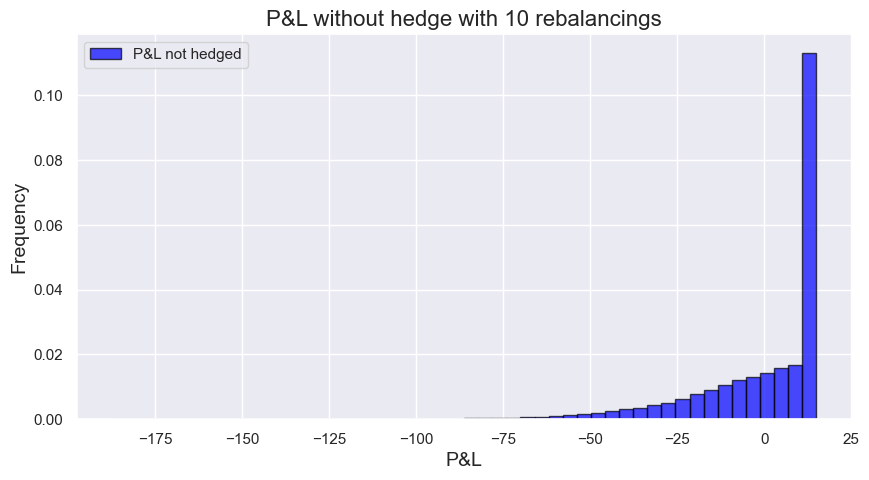

Statistics for the P&L not hedged:
{
    "Mean": 0.017426058650016785,
    "Var": 394.2511291503906,
    "Lower bound": -0.13459180295467377,
    "Upper bound": 0.16944392025470734
}


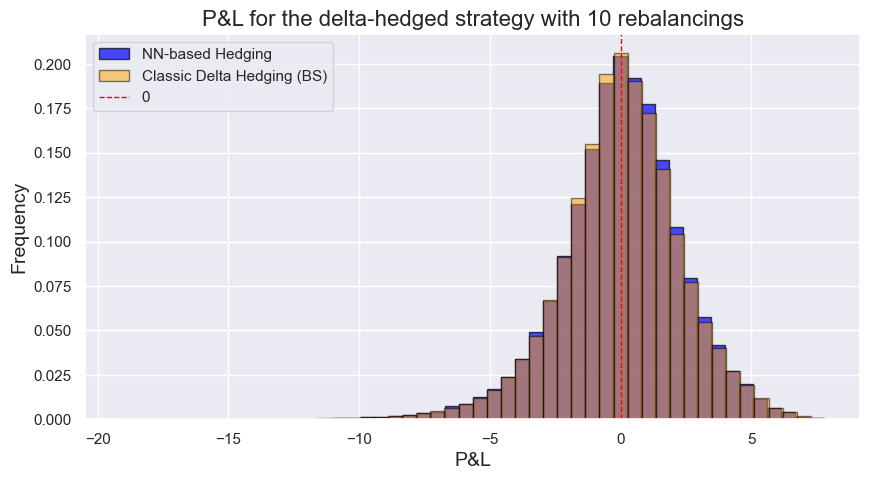

Statistics for the P&L from NN:
{
    "Mean": 0.009372483007609844,
    "Var": 5.425527095794678,
    "Lower bound": -0.008460708893835545,
    "Upper bound": 0.027205675840377808
}

Statistics for the classic delta hedged P&L:
{
    "Mean": 0.008788587525486946,
    "Var": 5.423339366912842,
    "Lower bound": -0.009041009470820427,
    "Upper bound": 0.02661818452179432
}


In [38]:
plot_pnl_distribution(N1, n_paths, S0, r, sigma, T, layers, theta_functions, cste, payoff_call, K)

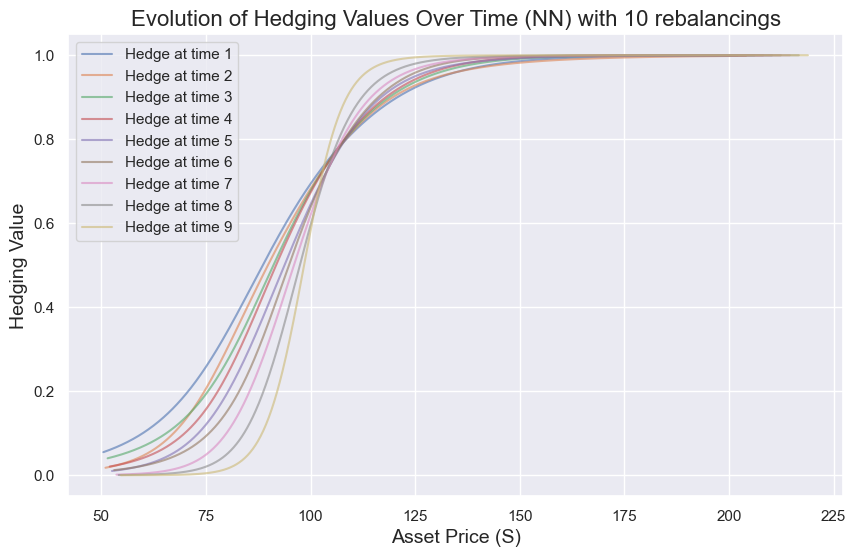

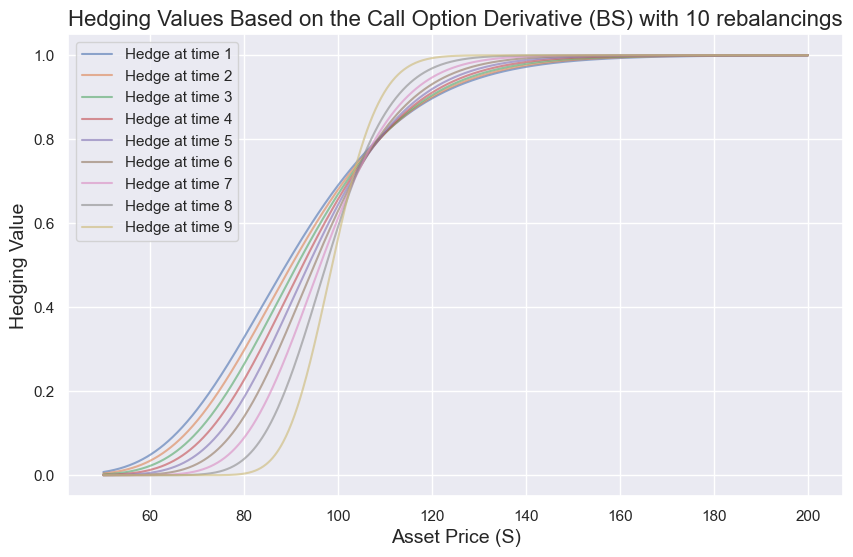

In [30]:
# We take the mean and std of the actualized prices we use within the Neural Network to fit the model
actu = np.exp(-r * np.arange(S1.shape[0]) * T / (S1.shape[0]-1))
S_actu = actu[:, None] * S1  
S_actu = torch.from_numpy(S_actu.astype(np.float32)).to("cpu")  # Convert to torch tensor and move to device
S_actu_mean = S_actu.mean()
S_actu_std = S_actu.std()
plot_hedging_strategies(N1, layers, theta_functions, S_actu_mean, S_actu_std, dprice_call_BS, T, r, sigma, K)

**1bis. We compute our best models and save them with 30 discretization steps**

In [31]:
N2 = 30
S2 = simu_S(N2, n_paths, S0, r , sigma , T)
theta_functions_2 = delta_hedge(S2,r, K, T, cste,payoff_call, loss_function, epochs, layers, lr, batch_size,weight_decay)

100%|███████████████████████████████████████████████████████████████████████| 20/20 [01:21<00:00,  4.07s/it, loss=1.95]


**2. We test our models on new independent paths (test if we did not overfitt) and compare the P&L with the delta hedged P&L**

<Figure size 1000x600 with 0 Axes>

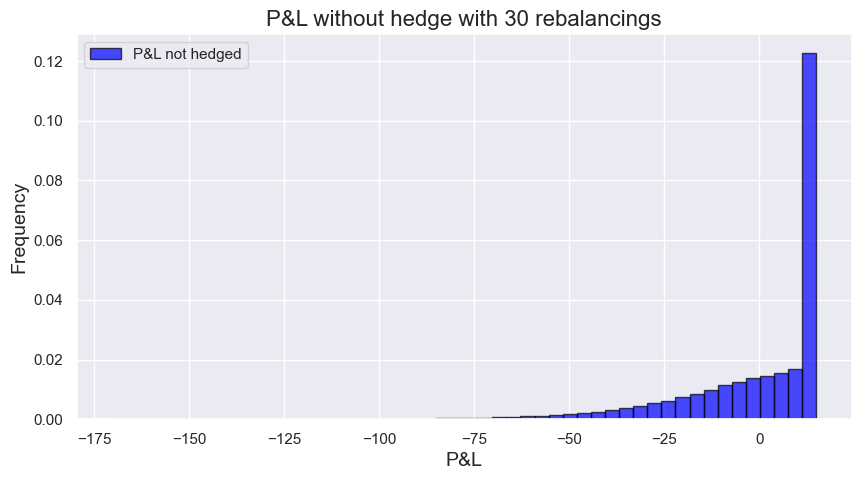

Statistics for the P&L not hedged:
{
    "Mean": -0.094868004322052,
    "Var": 405.9381103515625,
    "Lower bound": -0.24912257492542267,
    "Upper bound": 0.059386566281318665
}


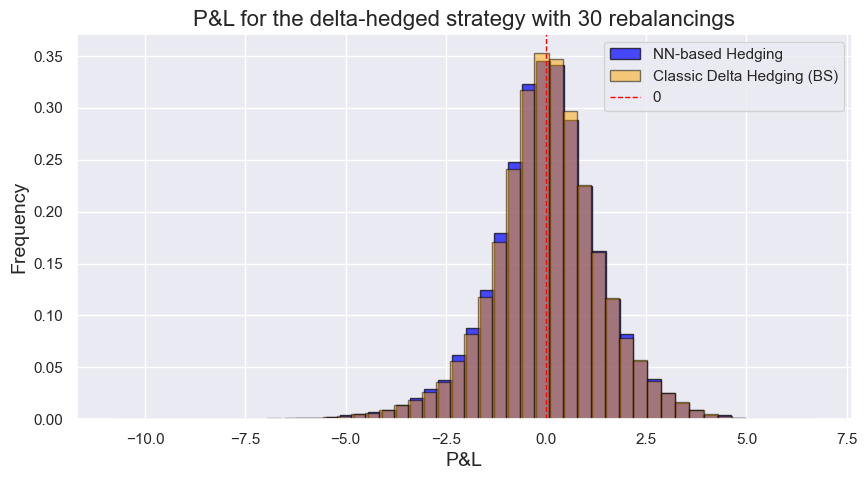

Statistics for the P&L from NN:
{
    "Mean": 0.0029488038271665573,
    "Var": 1.9309369325637817,
    "Lower bound": -0.007689984515309334,
    "Upper bound": 0.013587592169642448
}

Statistics for the classic delta hedged P&L:
{
    "Mean": 0.003246212610974908,
    "Var": 1.913628339767456,
    "Lower bound": -0.007344786077737808,
    "Upper bound": 0.013837210834026337
}


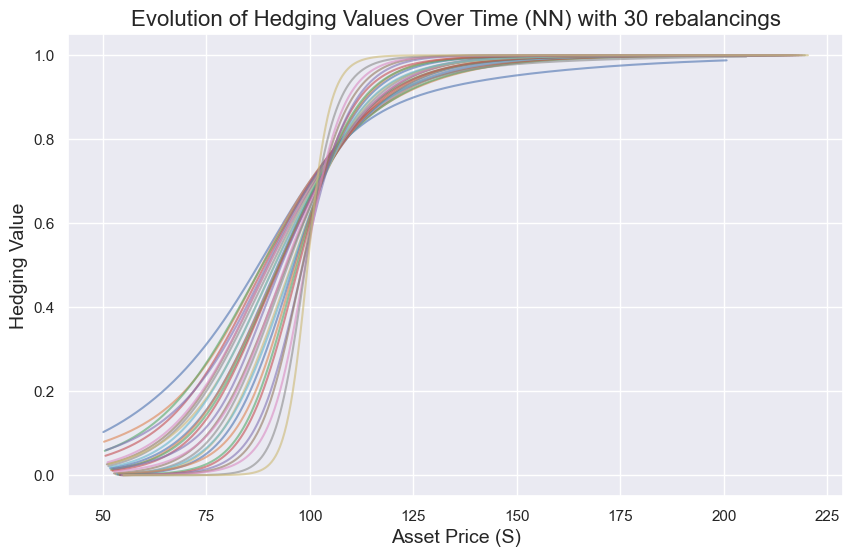

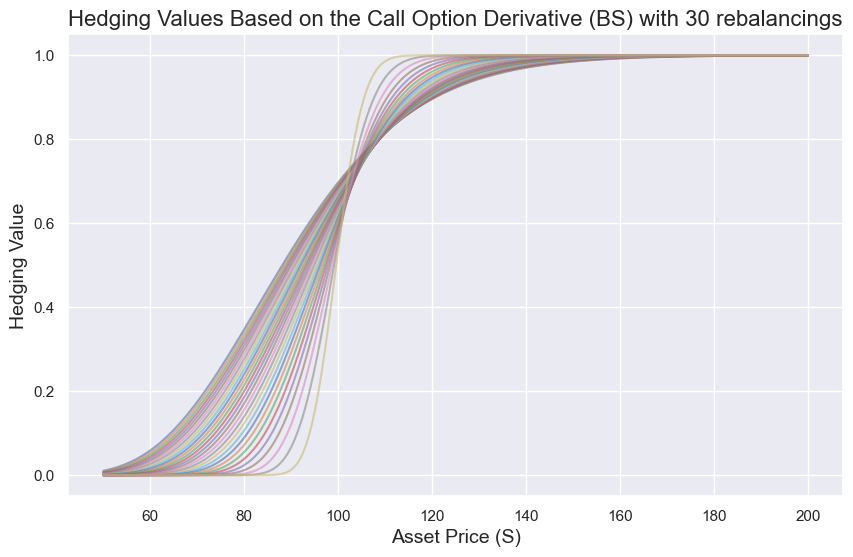

In [32]:
plot_pnl_distribution(N2, n_paths, S0, r, sigma, T, layers, theta_functions_2, cste, payoff_call, K)

# We take the mean and std of the actualized prices we use within the Neural Network to fit the model
actu = np.exp(-r * np.arange(S2.shape[0]) * T / (S2.shape[0]-1))
S_actu = actu[:, None] * S2  
S_actu = torch.from_numpy(S_actu.astype(np.float32)).to("cpu")  # Convert to torch tensor and move to device
S_actu_mean = S_actu.mean()
S_actu_std = S_actu.std()
plot_hedging_strategies(N2, layers, theta_functions_2, S_actu_mean, S_actu_std, dprice_call_BS, T, r, sigma, K)